In [65]:
# import all standard libraries
from datetime import datetime, date, timedelta
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import feather
import nltk

import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import uniform
from statistics import mean

Choose the dataset

In [7]:
data = pd.read_csv("data/cleaned-train-balanced-sarcasm-2.csv")

FileNotFoundError: [Errno 2] File data/cleaned-train-balanced-sarcasm-2.csv does not exist: 'data/cleaned-train-balanced-sarcasm-2.csv'

In [8]:
#data = pd.read_csv("data/train-balanced-sarcasm.csv")

In [9]:
data.dropna(subset=['comment'], inplace=True)
data.head(5)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [10]:
X_train, X_test, y_train, y_test = train_test_split(data['comment'], data['label'], random_state=15, test_size=0.2)

Hyperparameter Tuning 

In [11]:
kf = KFold(n_splits=5)

In [42]:
#applying tf-idf vectorizer
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

#candidates for c
test_c = [0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]

#dictionary to store the parameter value and its mean accuracy in cv
tuning_dict = {}
for i in test_c:
    
    #store the accuracy of each subsamples
    accuracy_list = []
    print(f"c = {i}")
    for train_index, test_index in kf.split(X_train):
        print("TRAIN:", train_index, "TEST:", test_index)
        
        X_train_cv, X_test_cv = X_train.reset_index(drop=True).loc[train_index, ], X_train.reset_index(drop=True).loc[test_index, ]
        y_train_cv, y_test_cv = y_train.reset_index(drop=True).loc[train_index, ], y_train.reset_index(drop=True).loc[test_index, ]    
        
        #applying logistic regression
        logit = LogisticRegression(C=i, n_jobs=8, solver='saga', random_state=17)

        #pipelining
        tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                         ('logit', logit)])
        tfidf_logit_pipeline.fit(X_train_cv, y_train_cv)
        valid_pred_lr = tfidf_logit_pipeline.predict(X_test_cv)
        
        accuracy_list.append(accuracy_score(y_test_cv, valid_pred_lr))
        print(accuracy_score(y_test_cv, valid_pred_lr))
    
    #calculate the mean of accuracies and add it to the dictionary
    print(mean(accuracy_list))
    tuning_dict[i] = mean(accuracy_list)


c = 0.5
TRAIN: [160858 160859 160860 ... 804285 804286 804287] TEST: [     0      1      2 ... 160855 160856 160857]
0.7154260279252509
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [160858 160859 160860 ... 321713 321714 321715]
0.7175894266993249
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [321716 321717 321718 ... 482571 482572 482573]
0.7179437764985267
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [482574 482575 482576 ... 643428 643429 643430]
0.7188123612898413
TRAIN: [     0      1      2 ... 643428 643429 643430] TEST: [643431 643432 643433 ... 804285 804286 804287]
0.7179171562319328
0.7175377497289753
c = 0.6
TRAIN: [160858 160859 160860 ... 804285 804286 804287] TEST: [     0      1      2 ... 160855 160856 160857]
0.7157555110718771
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [160858 160859 160860 ... 321713 321714 321715]
0.7178132265725049
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [321716 

In [43]:
max_accuracy = 0
best_c = 0
for i in test_c:
    if tuning_dict[i] >= max_accuracy:
        max_accuracy = tuning_dict[i]
        best_c = i
        
print(best_c)
print(max_accuracy)

0.7
0.7180524910295516


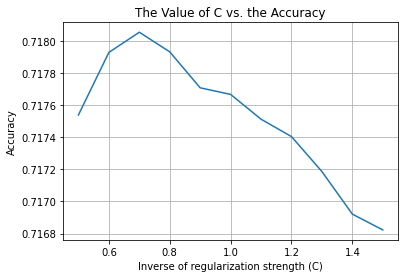

In [45]:
plt.plot(tuning_dict.keys(), tuning_dict.values())
plt.xlabel('Inverse of regularization strength (C)')
plt.ylabel('Accuracy')
plt.title('The Value of C vs. the Accuracy')
plt.grid(True)
plt.show()

In [47]:
logit = LogisticRegression(C=best_c, n_jobs=16, solver='saga', random_state=17)

#pipelining
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('logit', logit)])
tfidf_logit_pipeline.fit(X_train, y_train)
valid_pred_lr = tfidf_logit_pipeline.predict(X_test)

print(accuracy_score(y_test, valid_pred_lr))

0.7208959974536484


In [66]:
#hypertuning for mnb
#test_alpha = [5, 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6,6.1, 6.2, 6.3, 6.4, 6.5]
test_alpha = [1, 2, 3, 4, 5, 6, 7]
tuning_dict = {}
for i in test_alpha:
    accuracy_list = []
    print(i)
    for train_index, test_index in kf.split(X_train):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train_cv, X_test_cv = X_train.reset_index(drop=True).loc[train_index, ], X_train.reset_index(drop=True).loc[test_index, ]
        y_train_cv, y_test_cv = y_train.reset_index(drop=True).loc[train_index, ], y_train.reset_index(drop=True).loc[test_index, ]    
        #applying logistic regression
        mNB = MultinomialNB(alpha=i)

        #pipelining
        tfidf_mNB_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('mnb', mNB)])
        tfidf_mNB_pipeline.fit(X_train_cv, y_train_cv)
        valid_pred_mNB = tfidf_mNB_pipeline.predict(X_test_cv)
        accuracy_list.append(accuracy_score(y_test_cv, valid_pred_mNB))
        print(accuracy_score(y_test_cv, valid_pred_mNB))
    print(mean(accuracy_list))
    tuning_dict[i] = mean(accuracy_list)

1
TRAIN: [160858 160859 160860 ... 804285 804286 804287] TEST: [     0      1      2 ... 160855 160856 160857]
0.6946996730035186
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [160858 160859 160860 ... 321713 321714 321715]
0.6957316390854045
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [321716 321717 321718 ... 482571 482572 482573]
0.6968071218092976
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [482574 482575 482576 ... 643428 643429 643430]
0.695673797223621
TRAIN: [     0      1      2 ... 643428 643429 643430] TEST: [643431 643432 643433 ... 804285 804286 804287]
0.6969357876872004
0.6959696037618084
2
TRAIN: [160858 160859 160860 ... 804285 804286 804287] TEST: [     0      1      2 ... 160855 160856 160857]
0.694966989518706
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [160858 160859 160860 ... 321713 321714 321715]
0.6963470887366497
TRAIN: [     0      1      2 ... 804285 804286 804287] TEST: [321716 321717 321718 

In [67]:
max_accuracy = 0
best_alpha = 0
for i in test_alpha:
    if tuning_dict[i] >= max_accuracy:
        max_accuracy = tuning_dict[i]
        best_alpha = i
        
print(best_alpha)
print(max_accuracy)

6
0.6969593000434763


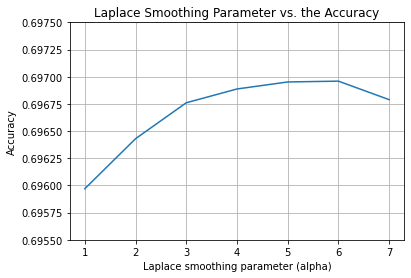

In [69]:
plt.plot(tuning_dict.keys(), tuning_dict.values())
plt.xlabel('Laplace smoothing parameter (alpha)')
plt.ylabel('Accuracy')
plt.title('Laplace Smoothing Parameter vs. the Accuracy')
plt.ylim(0.6955, 0.6975)
plt.grid(True)
plt.show()

In [71]:
mNB = MultinomialNB(alpha=best_alpha)

#pipelining
tfidf_mNB_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('mnb', mNB)])
tfidf_mNB_pipeline.fit(X_train, y_train)
valid_pred_mNB = tfidf_mNB_pipeline.predict(X_test)

print(accuracy_score(y_test, valid_pred_mNB))

0.698814355056895


In [25]:
tuning_dict.values()


dict_values([0.6969518398699267, 0.6969543265892904, 0.6969555699528368, 0.6969555700224016, 0.6969729767023928, 0.6969779501179316, 0.6969568134632425, 0.6969767068935149, 0.696971733477976, 0.6969816801235474, 0.6969593000434763, 0.6969916268154953, 0.696982923525741, 0.6969431367270316, 0.6969307034471204, 0.6968896734008059])

In [86]:
#applying RandomForest for classification

ranforest = RandomForestClassifier(n_jobs=36,random_state=15, class_weight='balanced', max_depth = 200, n_estimators = 1000)

tfidf_ranforest_pipeline = Pipeline([('tf_idf', tf_idf), 
                                 ('ranforest', ranforest)])
tfidf_ranforest_pipeline.fit(X_train, y_train)
valid_pred_ranforest = tfidf_ranforest_pipeline.predict(X_test)
print(accuracy_score(y_test, valid_pred_ranforest))

0.7021216280735258


In [87]:
print(accuracy_score(y_test, valid_pred_ranforest))

0.7021216280735258


In [88]:
report = classification_report(y_test, valid_pred_lr, output_dict=True)
df = pd.DataFrame(report)
df

,0,1,accuracy,macro avg,weighted avg
precision,0.704228,0.740097,0.720896,0.722163,0.722243
recall,0.757366,0.684752,0.720896,0.721059,0.720896
f1-score,0.729831,0.711350,0.720896,0.720590,0.720549
support,100085.000000,100987.000000,0.720896,201072.000000,201072.000000


In [89]:
report = classification_report(y_test, valid_pred_mNB, output_dict=True)
df = pd.DataFrame(report)
df

,0,1,accuracy,macro avg,weighted avg
precision,0.688860,0.709616,0.698814,0.699238,0.699285
recall,0.720218,0.677602,0.698814,0.698910,0.698814
f1-score,0.704190,0.693240,0.698814,0.698715,0.698690
support,100085.000000,100987.000000,0.698814,201072.000000,201072.000000


In [90]:
report = classification_report(y_test, valid_pred_ranforest, output_dict=True)
df = pd.DataFrame(report)
df


,0,1,accuracy,macro avg,weighted avg
precision,0.670092,0.747751,0.702122,0.708922,0.709096
recall,0.790988,0.614049,0.702122,0.702518,0.702122
f1-score,0.725538,0.674337,0.702122,0.699937,0.699823
support,100085.000000,100987.000000,0.702122,201072.000000,201072.000000


In [91]:
def vote(y_mnb, y_lr, y_rf):
    return (y_mnb+y_lr+y_rf)//2

In [92]:
valid_pred_voted = vote(valid_pred_mNB, valid_pred_lr, valid_pred_ranforest)
report = classification_report(y_test, valid_pred_voted, output_dict=True)
df = pd.DataFrame(report)
df


,0,1,accuracy,macro avg,weighted avg
precision,0.700071,0.747125,0.721359,0.723598,0.723704
recall,0.770165,0.672988,0.721359,0.721576,0.721359
f1-score,0.733447,0.708121,0.721359,0.720784,0.720727
support,100085.000000,100987.000000,0.721359,201072.000000,201072.000000


In [83]:
pd.Series([0, 1, 2 ,3])//2

0    0
1    0
2    1
3    1
dtype: int64